# Artificial neural networks

## Learning objectives

- Know the possibilities, architecture and key components of an artificial neural network.
- Understand how neural networks are trained.
- Learn how to build neural networks with [PyTorch](https://pytorch.org/).

## Environment setup

In [74]:
# Install library containing helper functions
%pip install pyfit


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
import platform

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import sklearn
from sklearn.datasets import make_circles

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from pyfit.plot import plot_loss_acc

In [39]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

In [40]:
# Utility functions


def plot_activation_function(f, f_prime, name, axis=(-6, 6, -1.1, 1.1)):
    """Plot an activation function and its derivative"""

    x_min, x_max = axis[0], axis[1]

    z = np.linspace(x_min, x_max, 200)
    plt.plot(z, f(z), "b-", linewidth=2, label=name)
    plt.plot(z, f_prime(z), "g--", linewidth=2, label=f"{name}'")
    plt.xlabel("x")
    plt.ylabel(f"{name}(x)")
    plt.axis(axis)
    plt.legend(loc="upper left")
    plt.show()


def plot_dataset(x, y):
    """Plot a 2-dimensional dataset with associated classes"""

    plt.figure()
    plt.plot(x[y == 0, 0], x[y == 0, 1], "or", label=0)
    plt.plot(x[y == 1, 0], x[y == 1, 1], "ob", label=1)
    plt.legend()
    plt.show()


def plot_decision_boundary(model, x, y):
    """Plot the frontier between classes for a 2-dimensional dataset"""

    plt.figure()

    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Compute model output for the whole grid
    z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    z = z.reshape(xx.shape)
    # Convert PyTorch tensor to NumPy
    zz = z.cpu().detach().numpy()
    # Plot the contour and training examples
    plt.contourf(xx, yy, zz, cmap=plt.colormaps.get_cmap("Spectral"))
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright)
    plt.show()


def count_parameters(model, trainable=True):
    """Return the total number of (trainable) parameters for a model"""

    return (
        sum(p.numel() for p in model.parameters() if p.requires_grad)
        if trainable
        else sum(p.numel() for p in model.parameters())
    )


def plot_fashion_images(data, labels, model=None):
    """Plot some images with their associated labels"""

    figure = plt.figure(figsize=(10, 6))
    cols, rows = 7, 4
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)

        # Title is either true or predicted label
        if model is None:
            title = labels[label]
        else:
            # Add a dimension (to match expected shape with batch size) and store image on device memory
            x_img = img[None, :].to(device)
            # Compute predicted label for image
            # Even if the model outputs unormalized logits, argmax gives the predicted label
            pred_label = model(x_img).argmax(dim=1).item()
            title = f"{labels[pred_label]}?"
        plt.title(title)

        plt.axis("off")
        plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.show()

In [41]:
# Print environment info
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"PyTorch version: {torch.__version__}")


# PyTorch device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA GPU {torch.cuda.get_device_name(0)} found :)")
# Performance issues exist with MPS backend
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("MPS GPU found :)")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

Python version: 3.11.1
NumPy version: 1.26.4
scikit-learn version: 1.4.1.post1
PyTorch version: 2.0.1
No GPU found, using CPU instead


## Fundamentals

### Online playground

[![TensorFlow playground](_images/tf_playground.png)](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=2&seed=0.59857&showTestData=false&discretize=false&percTrainData=30&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false&problem_hide=true&regularization_hide=true&regularizationRate_hide=true&percTrainData_hide=false)

### History

#### A biological inspiration

![Neuron](_images/neuron.png)

#### McCulloch & Pitts' formal neuron (1943)

![Formal neuron model](_images/neuron_model.jpeg)

#### Hebb's rule (1949)

Attempt to explain synaptic plasticity, the adaptation of brain neurons during the learning process.

> "The general idea is an old one, that any two cells or systems of cells that are repeatedly active at the same time will tend to become 'associated' so that activity in one facilitates activity in the other."

#### Franck Rosenblatt's perceptron (1958)

![The Perceptron](_images/Perceptron.jpg)

#### The perceptron learning algorithm

1. Init randomly the connection weights $\pmb{\omega}$.
1. For each training sample $\pmb{x}^{(i)}$:
    1. Compute the perceptron output $y'^{(i)}$
    1. Adjust weights : $\pmb{\omega_{t+1}} = \pmb{\omega_t} + \eta (y^{(i)} - y'^{(i)}) \pmb{x}^{(i)}$

#### Minsky's critic (1969)

One perceptron cannot learn non-linearly separable functions.

![XOR problem](_images/xor.png)

At the time, no learning algorithm existed for training the hidden layers of a MLP.

#### Decisive breakthroughs (1970s-1990s)

- 1974: backpropagation theory (P. Werbos).
- 1986: learning through backpropagation (Rumelhart, Hinton, Williams).
- 1989: first researchs on deep neural nets (LeCun, Bengio).
- 1991: Universal approximation theorem. Given appropriate complexity and appropriate learning, a network can theorically approximate any continuous function.

### Key components

#### Anatomy of a fully connected network

![A neural network](_images/nn_weights.png)

#### Neuron output

![Neuron output](_images/neuron_output.png)

#### Activation functions

They are applied to the weighted sum of neuron inputs to produce its output.

They must be:

- **non-linear**, so that the network has access to a richer representation space and not only linear transformations;
- **differentiable**, so that gradients can be computed during learning.

##### Sigmoid

This function "squashes" its input between between 0 and 1, outputting something that can be interpreted as the probability of the positive class. It is often used in the final layer of the network for binary classification tasks.

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})^2} = \sigma(x)\big(1 - \sigma(x)\big)$$

In [42]:
def sigmoid(x):
    """Sigmoid function"""

    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    """Derivative of the sigmoid function"""

    return sigmoid(x) * (1 - sigmoid(x))

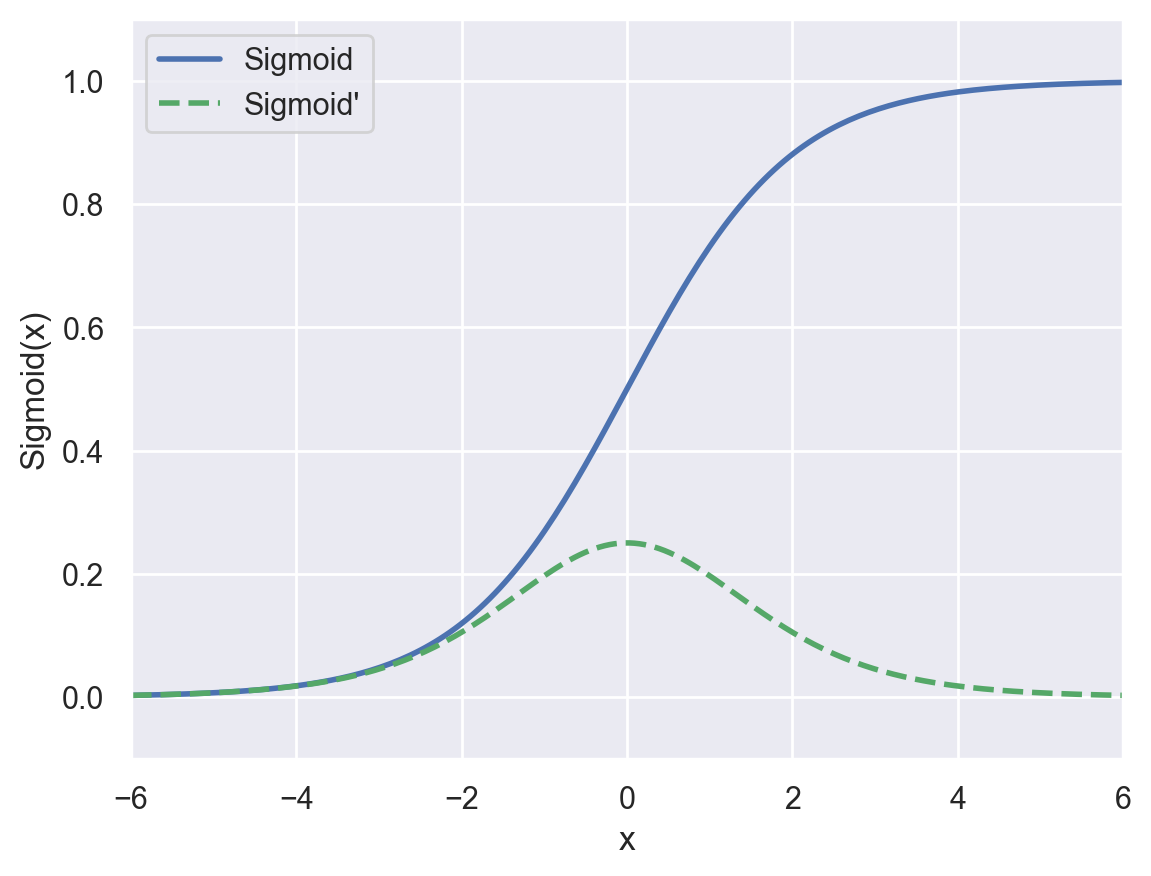

In [43]:
plot_activation_function(sigmoid, sigmoid_prime, "Sigmoid", axis=(-6, 6, -0.1, 1.1))

##### tanh

The hyperbolic tangent function has a similar shape as sigmoid, but outputs values in the $[-1,1]$ interval.

$$tanh(x) = \frac{sinh(x)}{cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{2}{1+e^{-2x}} -1 = 2\sigma(2x) - 1$$

$$tanh'(x) = \frac{4}{(e^x + e^{-x})^2} = \frac{1}{cosh^2(x)}$$

In [44]:
def tanh(x):
    """Hyperbolic tangent function"""

    return 2 * sigmoid(2 * x) - 1


def tanh_prime(x):
    """Derivative of hyperbolic tangent function"""

    return 4 / np.square(np.exp(x) + np.exp(-x))

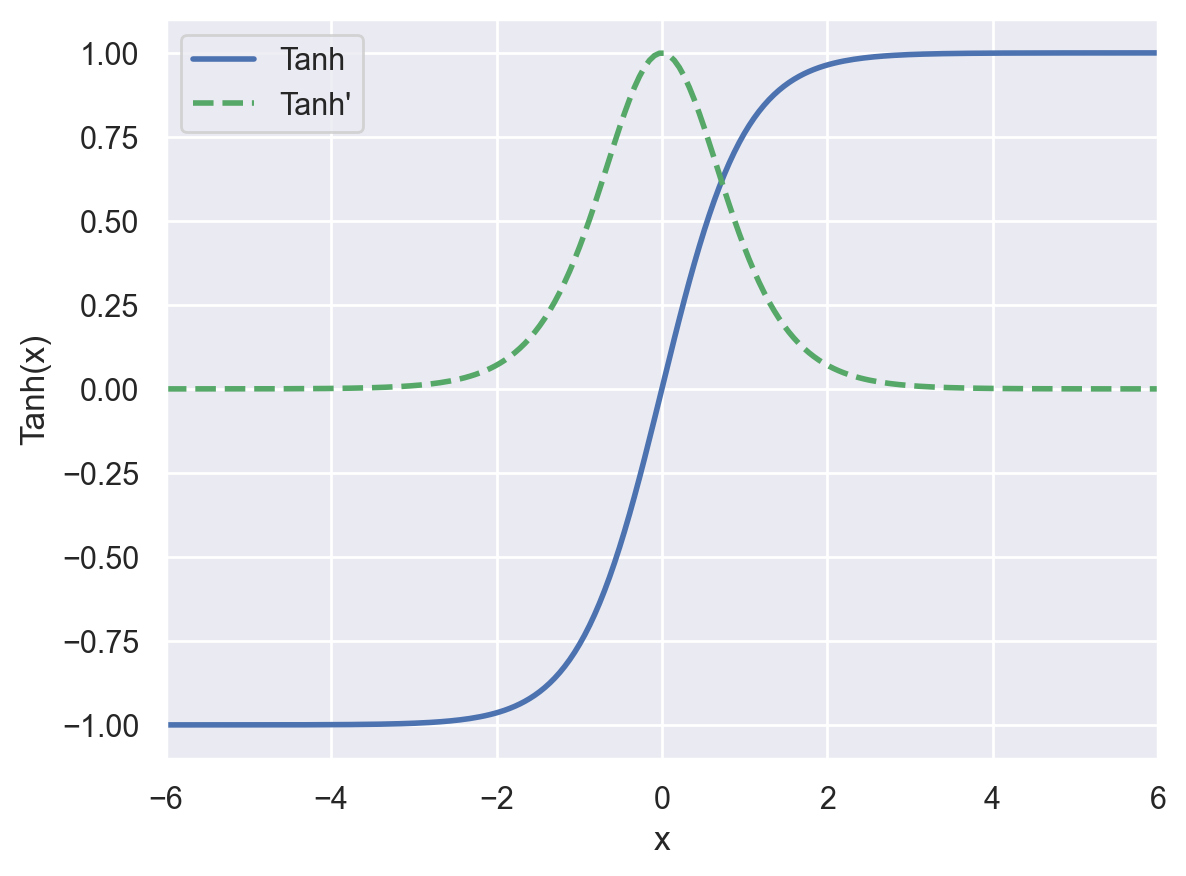

In [45]:
plot_activation_function(tanh, tanh_prime, "Tanh", axis=(-6, 6, -1.1, 1.1))

##### ReLU

The Rectified Linear Unit function has replaced sigmoid and tanh as the default activation function in most contexts.

$$ReLU(x) = max(0,x)$$

$$ReLU'(x) =
    \begin{cases}
      0 \; \forall x \in\; ]-\infty, 0] \\
      1 \; \forall x \in\; ]0, +\infty[
    \end{cases}$$

In [46]:
def relu(x):
    """Rectified Linear Unit function"""

    return np.maximum(0, x)


def relu_prime(x):
    """Derivative of the Rectified Linear Unit function"""

    # https://stackoverflow.com/a/45022037
    return (x > 0).astype(x.dtype)

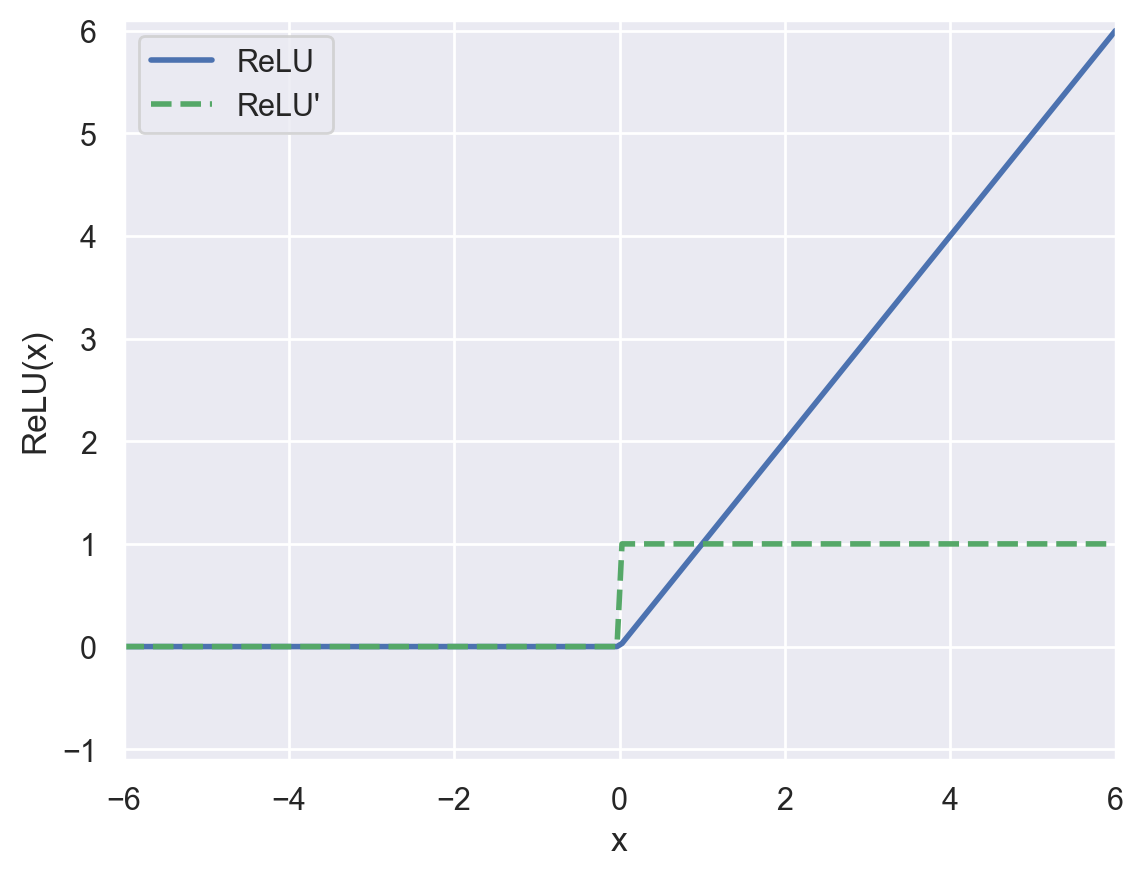

In [47]:
plot_activation_function(relu, relu_prime, "ReLU", axis=(-6, 6, -1.1, 6.1))

### Training process

#### Learning algorithm

[![Extract from the book Deep Learning with Python](_images/nn_learning.jpg)](https://www.manning.com/books/deep-learning-with-python)

#### Weights initialization

To facilitate training, initial weights must be:

- non-zero
- random
- have small values

[Several techniques exist](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79). A commonly used one is [Xavier initialization](https://proceedings.mlr.press/v9/glorot10a.html).

#### Weights update

Objective: minimize the loss function. Method: [gradient descent](principles.ipynb).

$$\pmb{\omega_{t+1}} = \pmb{\omega_t} - \eta\nabla_{\pmb{\omega}}\mathcal{L}(\pmb{\omega_t})$$

#### Backpropagation

Objective: compute $\nabla_{\pmb{\omega}}\mathcal{L}(\pmb{\omega_t})$, the loss function gradient w.r.t. all the network weights.

Method: apply the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) to compute partial derivatives backwards, starting from the current output.

$$y = f(g(x)) \;\;\;\; \frac{\partial y}{\partial x} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x}\;\;\;\; \frac{\partial y}{\partial x} = \sum_{i=1}^n \frac{\partial f}{\partial g^{(i)}} \frac{\partial g^{(i)}}{\partial x}$$

#### Visual demo of backpropagation

[![Backprop explained visually](_images/visual_backprop_demo.png)](https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/crash-course/backprop-scroll)

## BInary classification example

### Data generation and visualization

A scikit-learn [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) is used to easily generate two-dimensional data with two classes.

In [48]:
# Generate 2D data (a large circle containing a smaller circle)
planar_data, planar_targets = make_circles(n_samples=500, noise=0.1, factor=0.3)

print(f"Data: {planar_data.shape}. targets: {planar_targets.shape}")
print(planar_data[:10])
print(planar_targets[:10])

Data: (500, 2). targets: (500,)
[[-0.17484517 -0.24930221]
 [-0.40408387  0.2682799 ]
 [ 0.94435609  0.15306933]
 [ 0.93701015 -0.40535873]
 [ 0.94813686  0.57544557]
 [ 0.29669816 -0.10540653]
 [ 0.9945163  -0.14782202]
 [-0.20949356  0.35725974]
 [-0.85952503 -0.29925765]
 [ 0.31498329  0.02076161]]
[1 1 0 0 0 1 0 1 0 1]


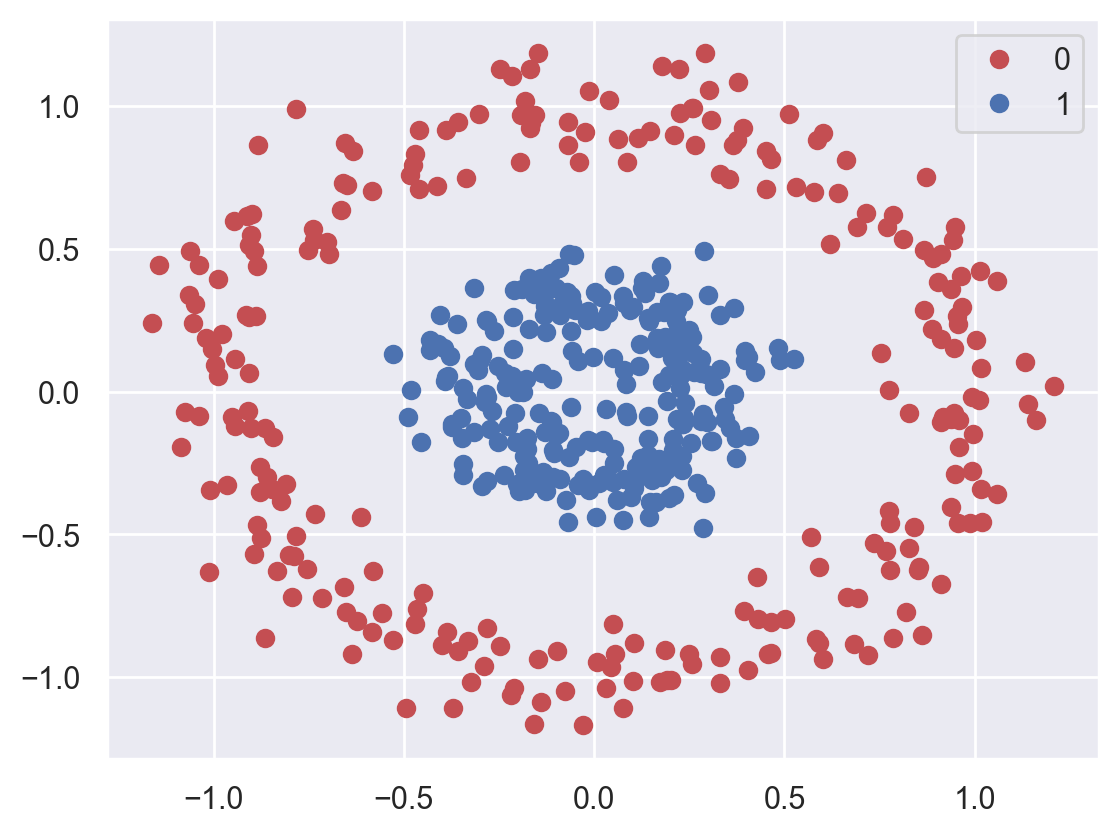

In [49]:
plot_dataset(planar_data, planar_targets)

### Hyperparameters

Hyperparameters ($\neq$ model parameters) are adjustable configuration values that let you control the model training process.

In [50]:
# Rate of parameter change during gradient descent
learning_rate = 0.1

# An epoch is finished when all data samples have been presented to the model during training
n_epochs = 50

# Number of samples used for one gradient descent step during training
batch_size = 5

# Number of neurons on the hidden layer of the MLP
hidden_layer_size = 2

### Data preparation

Generated data (NumPy tensors) needs to be converted to PyTorch tensors before training a PyTorch-based model. These new tensors are stored in the memory of the available device (GPU ou CPU).

In [51]:
# Create PyTorch tensors from NumPy tensors

x_train = torch.from_numpy(planar_data).float().to(device)

# PyTorch loss function expects float results of shape (batch_size, 1) instead of (batch_size,)
# So we add a new axis and convert them to floats
y_train = torch.from_numpy(planar_targets[:, np.newaxis]).float().to(device)

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")

x_train: torch.Size([500, 2]). y_train: torch.Size([500, 1])


In order to use [mini-batch SGD](principles.ipynb), data needs to be passed to the model as small, randomized batches during training. The Pytorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class abstracts this complexity for us.

In [52]:
# Load data as randomized batches for training
planar_dataloader = DataLoader(
    list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True
)

### Model definition

A PyTorch model is defined by combining elementary blocks, known as *modules*.

Our neural network uses the following ones:
- [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html): an ordered container of modules.
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): a linear transformation of its entries, a.k.a. *dense* or *fully connected* layer.
- [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) and [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html): the corresponding activation functions.

In [53]:
# Create a MultiLayer Perceptron with 2 inputs and 1 output
# You may change its internal architecture:
# for example, try adding one neuron on the hidden layer and check training results
planar_model = nn.Sequential(
    # Hidden layer with 2 inputs
    nn.Linear(in_features=2, out_features=hidden_layer_size),
    nn.Tanh(),
    # Output layer
    nn.Linear(in_features=hidden_layer_size, out_features=1),
    nn.Sigmoid(),
).to(device)
print(planar_model)

# Count the total number of trainable model parameters (weights)
print(f"Number of trainable parameters: {count_parameters(planar_model)}.")

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)
Number of trainable parameters: 9.


### Loss function

For binary classification tasks, the standard choice is the [binary cross entropy loss](classification.ipynb), conveniently provided by a [PyTorch class](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

For each sample of the batch, it will compare the output of the model (a value $\in [0,1]$ provided by the sigmoid function) with the expected binary value $\in \{0,1\}$.

In [54]:
# Binary cross entropy loss function
planar_loss_fn = nn.BCELoss()

### Model training

The training algorithm is as follows:
- On each iteration on the whole dataset (known as an *epoch*) and for each data batch inside an epoch, the model output is computed on the current batch.
- This output is used alongside expected results by the loss function to obtain the mean loss for the current batch.
- The gradient of the loss w.r.t. each model parameter is computed (backpropagation).
- The model parameters are updated in the opposite direction of their gradient (one GD step).


In [55]:
def train_planar(dataloader, model, loss_fn, epochs):
    """Main training code"""

    # Object storing training history
    history = {"loss": [], "acc": []}

    # Number of samples
    n_samples = len(dataloader.dataset)

    # Number of batches in an epoch (= n_samples / batch_size, rounded up)
    n_batches = len(dataloader)

    print(f"Training started! {n_samples} samples. {n_batches} batches per epoch")

    for epoch in range(epochs):
        # Reset total loss for the current epoch
        total_loss = 0

        # Reset number of correct predictions for the current epoch
        n_correct = 0

        # Training loop for one data batch (i.e. one gradient descent step)
        for x_batch, y_batch in dataloader:
            # Zero the gradients before running the backward pass
            # Avoids accumulating gradients erroneously
            model.zero_grad()

            # Forward pass: compute model output with current weights
            output = model(x_batch)

            # Compute loss (comparison between expected and actual results)
            loss = loss_fn(output, y_batch)

            # Backward pass (backprop): compute gradient of the loss w.r.t each model weight
            loss.backward()

            # Gradient descent step: update the weights in the opposite direction of their gradient
            # no_grad() avoids tracking operations history, which would be useless here
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad

                # Accumulate data for epoch metrics: loss and number of correct predictions
                total_loss += loss.item()
                n_correct += (
                    (torch.round(model(x_batch)) == y_batch).float().sum().item()
                )

        # Compute epoch metrics
        epoch_loss = total_loss / n_batches
        epoch_acc = n_correct / n_samples

        print(
            f"Epoch [{(epoch + 1):3}/{epochs:3}]. Mean loss: {epoch_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

        # Record epoch metrics for later plotting
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

    print(f"Training complete! Total gradient descent steps: {epochs * n_batches}")

    return history

In [56]:
planar_history = train_planar(
    dataloader=planar_dataloader,
    model=planar_model,
    loss_fn=planar_loss_fn,
    epochs=n_epochs,
)

Training started! 500 samples. 100 batches per epoch
Epoch [  1/ 50]. Mean loss: 0.69666. Accuracy: 53.80%
Epoch [  2/ 50]. Mean loss: 0.69245. Accuracy: 58.00%
Epoch [  3/ 50]. Mean loss: 0.68901. Accuracy: 62.20%
Epoch [  4/ 50]. Mean loss: 0.68247. Accuracy: 68.60%
Epoch [  5/ 50]. Mean loss: 0.67266. Accuracy: 75.00%
Epoch [  6/ 50]. Mean loss: 0.64818. Accuracy: 80.40%
Epoch [  7/ 50]. Mean loss: 0.61079. Accuracy: 84.60%
Epoch [  8/ 50]. Mean loss: 0.56403. Accuracy: 85.00%
Epoch [  9/ 50]. Mean loss: 0.51661. Accuracy: 85.60%
Epoch [ 10/ 50]. Mean loss: 0.48368. Accuracy: 85.60%
Epoch [ 11/ 50]. Mean loss: 0.45784. Accuracy: 85.80%
Epoch [ 12/ 50]. Mean loss: 0.43980. Accuracy: 85.20%
Epoch [ 13/ 50]. Mean loss: 0.42826. Accuracy: 86.00%
Epoch [ 14/ 50]. Mean loss: 0.41968. Accuracy: 85.00%
Epoch [ 15/ 50]. Mean loss: 0.41230. Accuracy: 85.20%
Epoch [ 16/ 50]. Mean loss: 0.40578. Accuracy: 86.20%
Epoch [ 17/ 50]. Mean loss: 0.40196. Accuracy: 85.80%
Epoch [ 18/ 50]. Mean loss: 0

### Training results

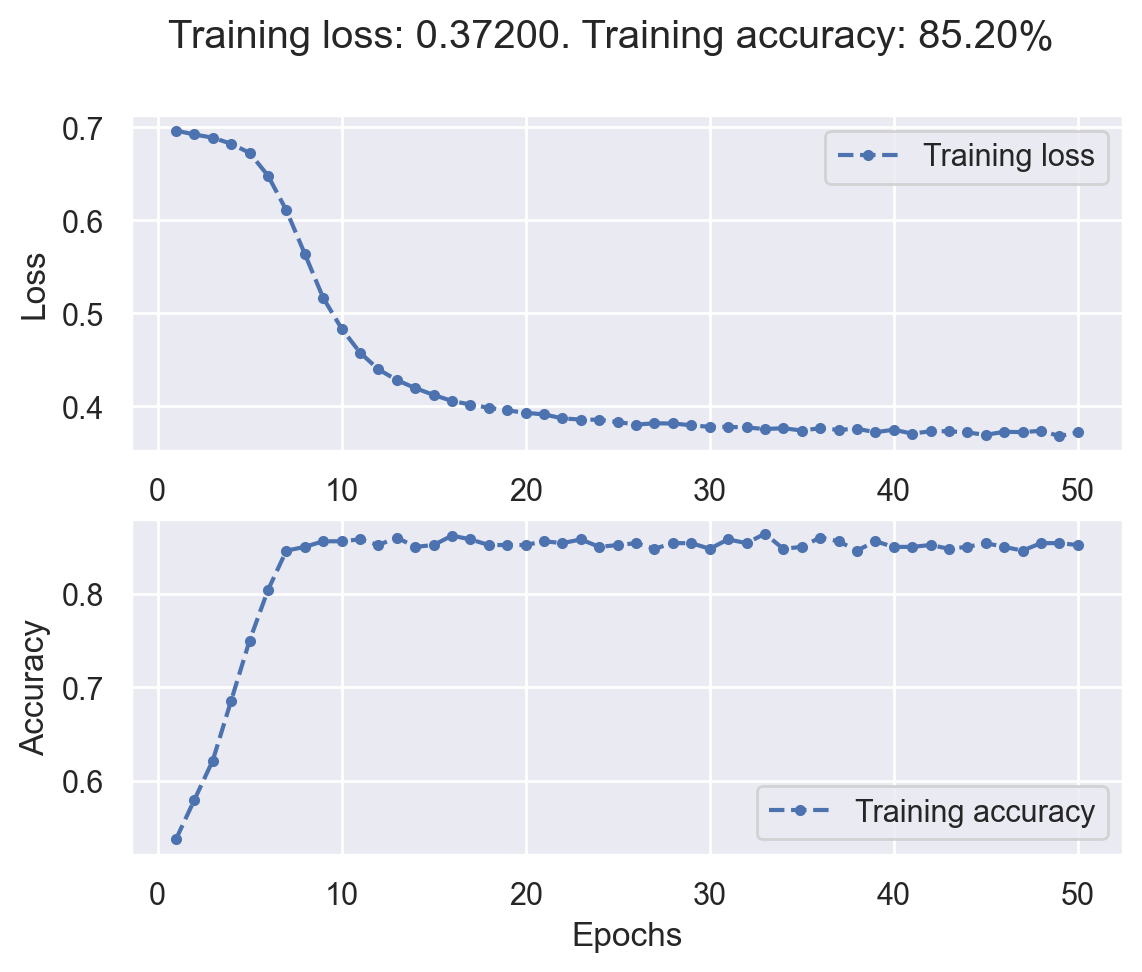

In [57]:
plot_loss_acc(planar_history)

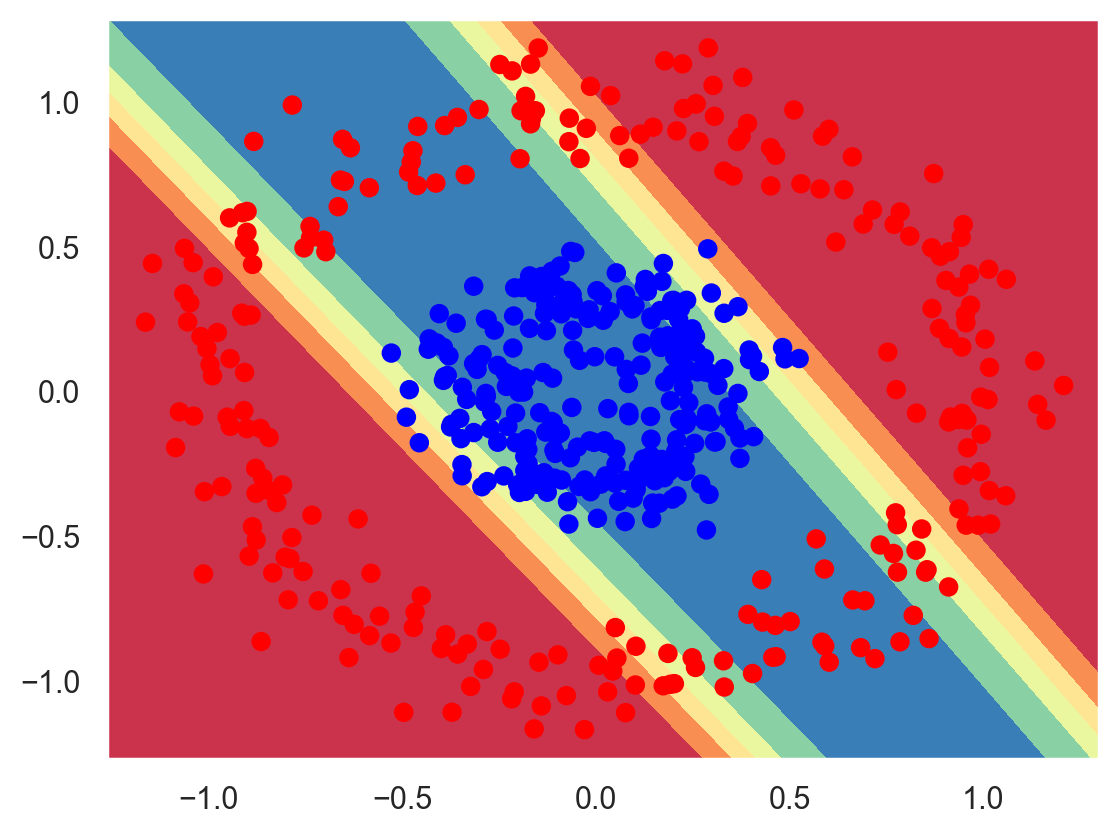

In [58]:
plot_decision_boundary(planar_model, planar_data, planar_targets)

## Multiclass classification example

### Data loading and visualization

We use the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, analogous to the famous MNIST handwritten digits dataset. It consists of:
- a training set containing 60,000 28x28 grayscale images, each of them associated with a label (fashion category) from 10 classes;
- a test set of 10,000 images with the same properties.

A [PyTorch class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) simplifies the loading process of this dataset.

In [59]:
fashion_train_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

fashion_test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

In [60]:
# Show info about the first training image
fashion_img, fashion_label = fashion_train_data[0]

print(f"First image: {fashion_img.shape}. Label: {fashion_label}")

First image: torch.Size([1, 28, 28]). Label: 9


In [61]:
# Show raw data for the first image
# Pixel values have already been normalized into the [0,1] range
print(fashion_img)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [62]:
# Labels, i.e. fashion categories associated to images (one category per image)
fashion_labels = (
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

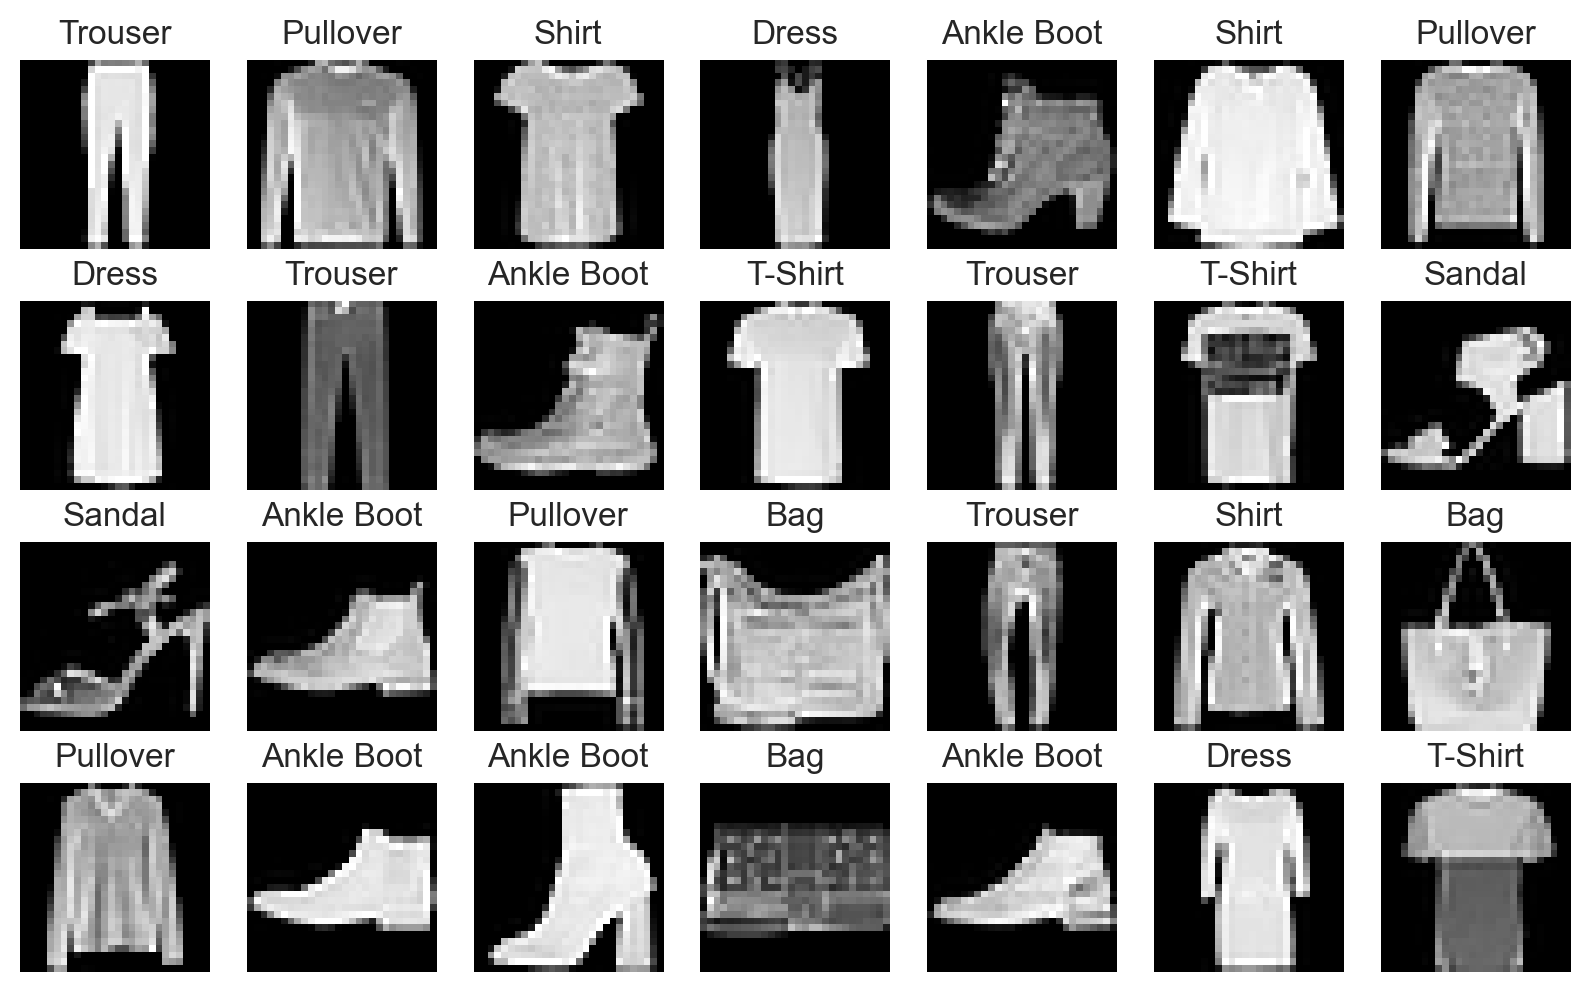

In [63]:
plot_fashion_images(fashion_train_data, fashion_labels)

### Hyperparameters

In [64]:
# Try to change the learning rate to 1e-2 ans check training results
learning_rate = 1e-3
n_epochs = 10
batch_size = 64

### Data preparation

As always, data will be passed to the model as small, randomized batches during training.

In [65]:
fashion_train_dataloader = DataLoader(fashion_train_data, batch_size=batch_size)
fashion_test_dataloader = DataLoader(fashion_test_data, batch_size=batch_size)

### Model definition

Most PyTorch models are defined as subclasses of the [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class. Their constructor creates the layer architecture and their `forward` method defines the forward pass of the model.

In this model, we use the [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) module that transforms an input tensor of any shape into a vector (hence its name).

In [66]:
class NeuralNetwork(nn.Module):
    """Neural network for fashion articles classification"""

    def __init__(self):
        super().__init__()

        # Flatten the input image of shape (1, 28, 28) into a vector of shape (28*28,)
        self.flatten = nn.Flatten()

        # Define a sequential stack of linear layers and activation functions
        self.layer_stack = nn.Sequential(
            # First hidden layer with 784 inputs
            nn.Linear(in_features=28 * 28, out_features=64),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            # Output layer
            nn.Linear(in_features=64, out_features=10),
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Apply flattening to input
        x = self.flatten(x)

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [67]:
fashion_model = NeuralNetwork().to(device)
print(fashion_model)

# Try to guess the total number of parameters for this model before running this code!
print(f"Number of trainable parameters: {count_parameters(fashion_model)}")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Number of trainable parameters: 55050


### Loss function

The standard choice for multiclass classification tasks is the [cross entropy loss](classification.ipynb) a.k.a. negative log-likelihood loss, provided by a PyTorch class aptly named [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

> PyTorch also offers the [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) class implementing the negative log-likelihood loss. A key difference is that `CrossEntropyLoss` expects *logits*  (raw, unnormalized predictions) as inputs, and uses [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) to transform them into probabilities before computing its output. Using `CrossEntropyLoss` is equivalent to applying `LogSoftmax` followed by `NLLLoss` ([more details](https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81)).

#### Softmax

The softmax function turns a vector $\pmb{v} = \{v_1, v_2, \dots, v_K \} \in \mathbb{R}^K$ of raws values (called a *logits vector* when it's the output of a ML model) into a probability distribution. It is a multiclass generalization of the sigmoid function.

$$\sigma(\pmb{v})_k = \frac{e^{v_k}}{\sum_{k=1}^K {e^{v_k}}}\;\;\;\;
\sum_{k=1}^K \sigma(\pmb{v})_k = 1$$

- $K$: number of labels.
- $\pmb{v}$: logits vector, i.e. raw predictions for each class.
- $\sigma(\pmb{v})_k \in [0,1]$: probability associated to label $k \in [1,K]$.

In [68]:
def softmax(x):
    """Softmax function"""

    return np.exp(x) / sum(np.exp(x))


# Raw values (logits)
raw_predictions = [3.0, 1.0, 0.2]

probas = softmax(raw_predictions)
print(probas)

# Sum of all probabilities is equal to 1
print(sum(probas))

[0.8360188  0.11314284 0.05083836]
0.9999999999999999


### Optimization algorithm

PyTorch provides out-of-the-box implementations for many gradient descent optimization algorithms ([Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), [RMSProp](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html), etc).

We'll stick with vanilla mini-batch SGD for now.

### Model training

In [69]:
def epoch_loop(dataloader, model, loss_fn, optimizer):
    """Training algorithm for one epoch"""

    total_loss = 0
    n_correct = 0

    for x_batch, y_batch in dataloader:
        # Load data and targets on device memory
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        # Backward pass: backprop and GD step
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Accumulate data for epoch metrics: loss and number of correct predictions
            total_loss += loss.item()
            n_correct += (model(x_batch).argmax(dim=1) == y_batch).float().sum().item()

    return total_loss, n_correct

In [70]:
def fit(dataloader, model, loss_fn, optimizer, epochs):
    """Main training code"""

    history = {"loss": [], "acc": []}
    n_samples = len(dataloader.dataset)
    n_batches = len(dataloader)

    print(f"Training started! {n_samples} samples. {n_batches} batches per epoch")

    for epoch in range(epochs):
        total_loss, n_correct = epoch_loop(dataloader, model, loss_fn, optimizer)

        # Compute epoch metrics
        epoch_loss = total_loss / n_batches
        epoch_acc = n_correct / n_samples

        print(
            f"Epoch [{(epoch + 1):3}/{epochs:3}]. Mean loss: {epoch_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

        # Record epoch metrics for later plotting
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

    print(f"Training complete! Total gradient descent steps: {epochs * n_batches}")

    return history

In [71]:
fashion_history = fit(
    dataloader=fashion_train_dataloader,
    model=fashion_model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(fashion_model.parameters(), lr=learning_rate),
    epochs=n_epochs,
)

Training started! 60000 samples. 938 batches per epoch
Epoch [  1/ 10]. Mean loss: 2.28511. Accuracy: 21.39%
Epoch [  2/ 10]. Mean loss: 2.22016. Accuracy: 32.51%
Epoch [  3/ 10]. Mean loss: 2.09399. Accuracy: 43.31%
Epoch [  4/ 10]. Mean loss: 1.86179. Accuracy: 47.05%
Epoch [  5/ 10]. Mean loss: 1.54342. Accuracy: 51.93%
Epoch [  6/ 10]. Mean loss: 1.29843. Accuracy: 58.08%
Epoch [  7/ 10]. Mean loss: 1.14948. Accuracy: 61.77%
Epoch [  8/ 10]. Mean loss: 1.05058. Accuracy: 64.02%
Epoch [  9/ 10]. Mean loss: 0.97873. Accuracy: 65.70%
Epoch [ 10/ 10]. Mean loss: 0.92317. Accuracy: 67.16%
Training complete! Total gradient descent steps: 9380


### Training results

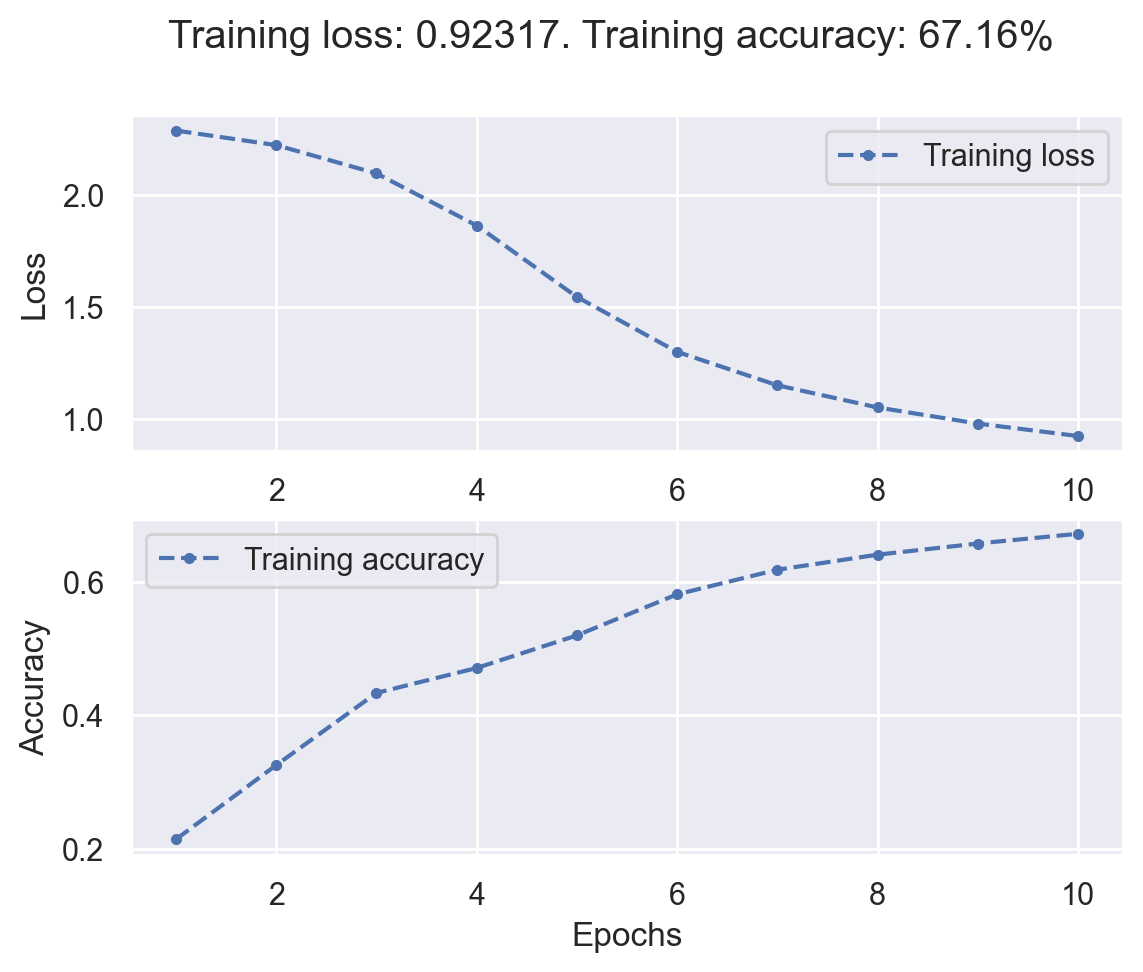

In [72]:
plot_loss_acc(fashion_history)

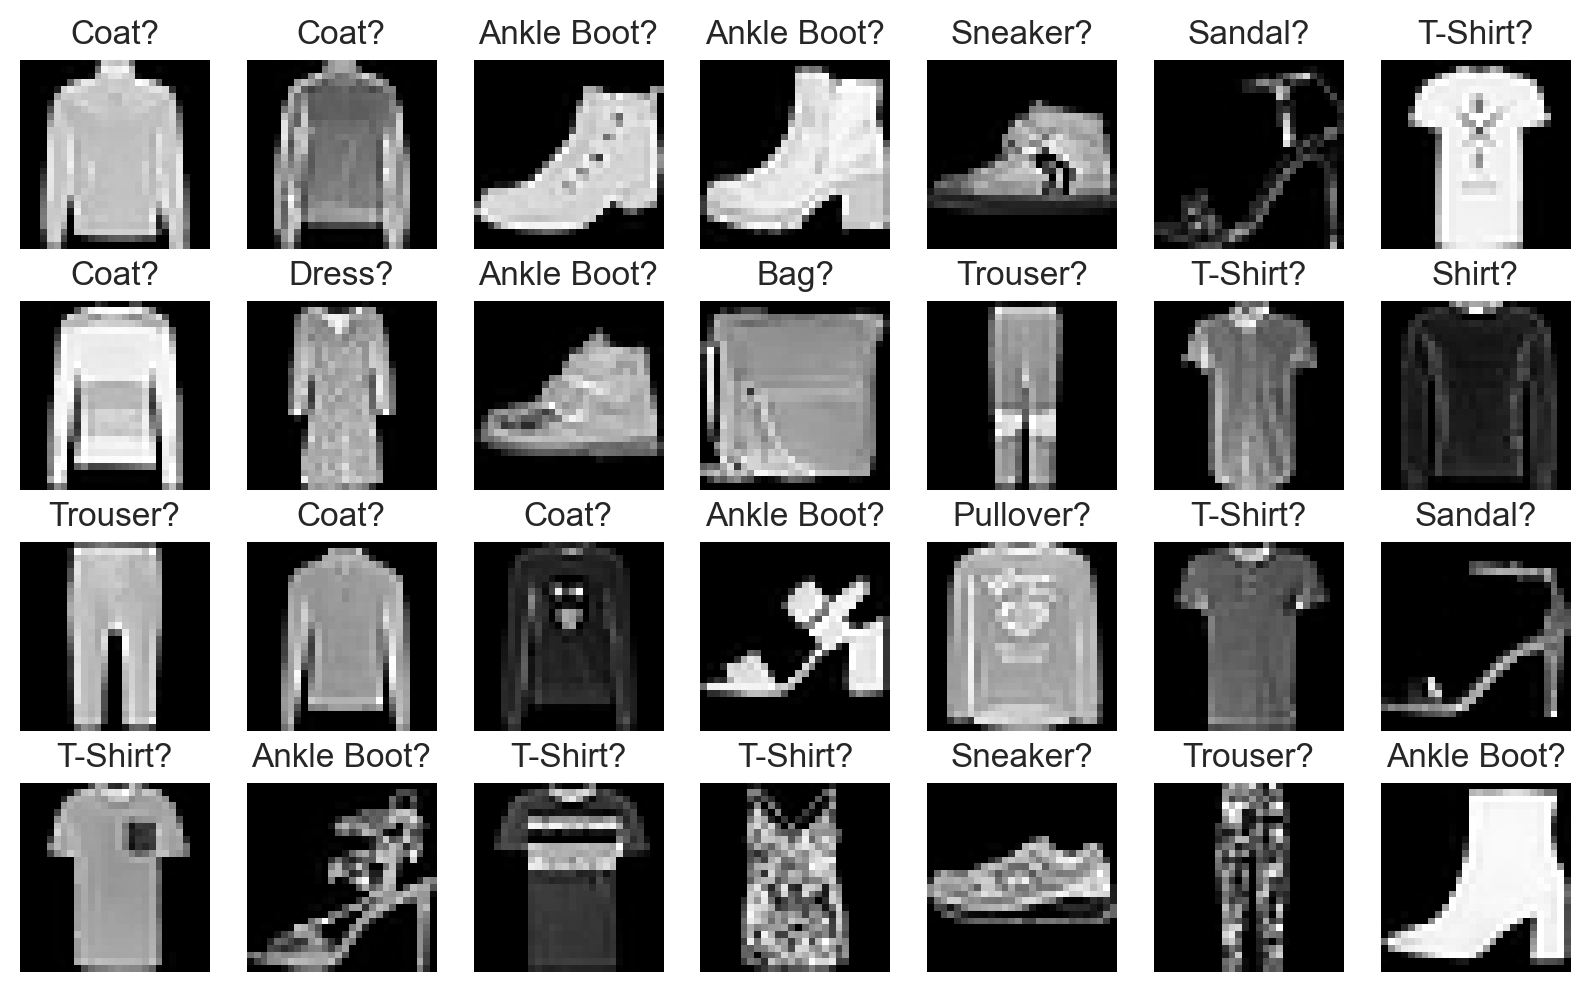

In [73]:
plot_fashion_images(fashion_train_data, fashion_labels, fashion_model)